In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, dual_annealing, basinhopping
import os 

from scipy.stats import betabinom, poisson, norm

import seaborn as sns


In [8]:

def opt_deconv(symptomatic_incidence, true_kernel, a=1E7, degree=2):

    def optimizer_function(all_r):

        L = len(true_kernel) - 1
        io = 1
        real_incidence = [io] # same length as symptomatic_incidence
#np.log(io)
        for r in all_r:
            io += (r*io)#np.log(r)
            real_incidence.append(io)

     #   real_incidence = np.exp(real_incidence)


        convolved = np.convolve(real_incidence, true_kernel, mode='valid')
        scaling = np.max(symptomatic_incidence[L:])

        
        scaled_incidence = symptomatic_incidence[L:] 

        penalty = a * np.sum(np.abs(np.diff(all_r)/len(all_r))**degree)#np.sum(np.abs(np.diff(real_incidence)/scaling/len(real_incidence))**degree)
        loglikelihoods = scaled_incidence*np.log(convolved) - convolved

        return -np.mean(loglikelihoods)+penalty


    x0 = [0.1 for _ in symptomatic_incidence[:-1]]#np.diff(np.log(symptomatic_incidence+1))
    xs = minimize(optimizer_function, x0, bounds=[(-1, 3) for _ in x0], options={'maxiter':1000}, method='Powell')
    return xs



In [9]:
simulation = pd.read_csv('data/process_noise_SEIR.csv')#Canada.csv') #process_noise_SEIR
incubation_period = pd.read_csv('incubation_period.csv')['seir']#['real_world']
obs_symptomatic_incidence = simulation['symptomatic_incidence'].to_numpy()#['new_cases_per_million'].to_numpy()*33


In [10]:
outs =opt_deconv(obs_symptomatic_incidence, incubation_period, a=1E0)

ValueError: diff requires input that is at least one dimensional

In [5]:
reconstruct = [1]
for r in outs.x:
    reconstruct.append(reconstruct[-1]*r+reconstruct[-1])

(0.5, -0.1)

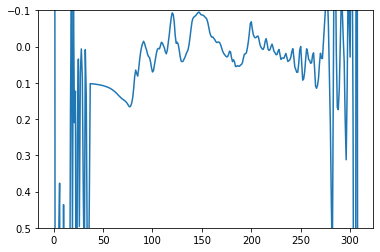

In [6]:
plt.plot(outs.x)
#plt.plot(np.concatenate([np.diff(simulation['scaled_true_incidence']), [0]])/simulation['scaled_true_incidence'])
plt.ylim(0.5, -0.1)

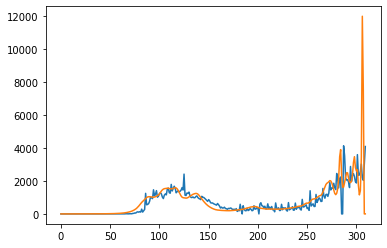

In [7]:
plt.plot(obs_symptomatic_incidence)
plt.plot(reconstruct)
#plt.plot(simulation['scaled_true_incidence'])